In [1]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (10, 6)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np

# confusion_matrixの結果からF値を計算する関数
def calculate_f1_from_confusion_matrix(cm):
    """
    confusion_matrixの結果からF1スコアを計算
    
    Args:
        cm: confusion_matrixの結果（2x2配列）
            [[TN, FP],
             [FN, TP]]
    
    Returns:
        float: F1スコア
    """
    # 2値分類の場合
    if cm.shape == (2, 2):
        TN, FP = cm[0, 0], cm[0, 1]
        FN, TP = cm[1, 0], cm[1, 1]
        
        # Precision = TP / (TP + FP)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        # Recall = TP / (TP + FN)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # F1 = 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return f1, precision, recall
    else:
        raise ValueError("2値分類用の関数です。多クラス分類の場合は別の関数を使用してください。")

In [3]:
# データ収集関数（既存の分析から再利用）
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

In [4]:
def collect_data_for_tree_analysis(logs_root='Logs'):
    """
    決定木・ランダムフォレスト用のデータを収集
    パラメータごとに5回実行の結果を集計
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごと）
            bug_results = []
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row == ['timeout']:
                        bug_results.append('timeout')
                    elif bug_row == ['null']:
                        bug_results.append('normal')
                    else:
                        bug_results.append('bug')
            
            # 5回実行の結果を集計
            if len(bug_results) >= 5:
                # 最初の5回のみを使用
                first_5_results = bug_results[:5]
                
                # バグ発見の有無（1回でもバグ発見があれば1）
                bug_detected_any = 1 if 'bug' in first_5_results else 0
                
                # 5回全てバグ発見（5回全てbugなら1）
                bug_detected_all = 1 if all(r == 'bug' for r in first_5_results) else 0
                
                
                # データポイントを作成
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'bug_detected_any': bug_detected_any,  # 1回でもバグ発見
                    'bug_detected_all': bug_detected_all,  # 5回全てバグ発見
                })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n1回でもバグ発見の分布:")
    print(df['bug_detected_any'].value_counts())
    print(f"\n5回全てバグ発見の分布:")
    print(df['bug_detected_all'].value_counts())
    return df

df_agg = collect_data_for_tree_analysis(logs_root="../Logs/")

データ収集完了: 2160件のレコード

データの基本統計:
              tree        cpNum  cpNum_range    cpNum_dir  bug_detected_any  \
count  2160.000000  2160.000000  2160.000000  2160.000000       2160.000000   
mean    500.000000   225.000000    50.000000     1.150000          0.844444   
std     408.342825   234.059885    40.017597     0.572409          0.362517   
min       0.000000     1.000000     1.000000     1.000000          0.000000   
25%       0.000000    50.000000     1.000000     1.000000          1.000000   
50%     500.000000   149.500000    50.000000     1.000000          1.000000   
75%    1000.000000   300.000000    99.000000     1.000000          1.000000   
max    1000.000000   700.000000    99.000000     4.000000          1.000000   

       bug_detected_all  
count       2160.000000  
mean           0.353241  
std            0.478087  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            1.000000  
max            1.000000  

1回でもバグ発見の分布:
bug_detec

# タスク2: 5回実行して5回ともバグ発見できるか


## モデルの構築・F値計算

In [5]:

# sklearnを使用したロジスティック回帰（予測精度の評価のため）
# 説明変数と目的変数の準備
X = df_agg[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df_agg['bug_detected_all']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ数: {len(X_train)}")
print(f"テストデータ数: {len(X_test)}")
print(f"\n訓練データの目的変数分布:")
print(y_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y_test.value_counts())

# 標準化（オプション：必要に応じて）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ロジスティック回帰モデルの学習
# lr_model = LogisticRegression(random_state=42, max_iter=1000)

# ハイパーパラメータを調整したモデル
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear',  C=np.float64(0.01), penalty='l1', class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# 予測
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]


訓練データ数: 1728
テストデータ数: 432

訓練データの目的変数分布:
bug_detected_all
0    1118
1     610
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_all
0    279
1    153
Name: count, dtype: int64



【今回のモデル】
Accuracy:  0.6921
Precision: 0.5450
Recall:    0.7908
F1-Score:  0.6453
AUC:       0.7946

【混同行列】
[[178 101]
 [ 32 121]]

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

【混同行列】


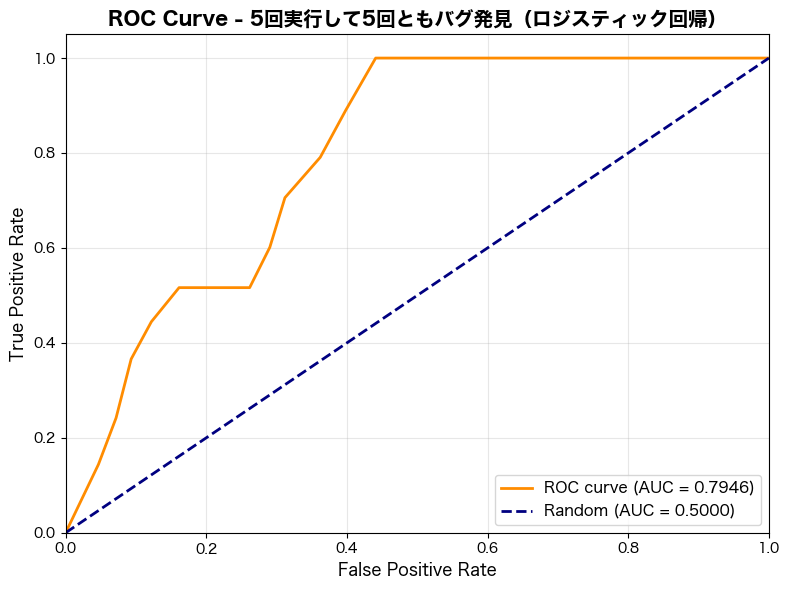

In [6]:
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# AUC計算
auc_score = roc_auc_score(y_test, y_pred_proba)


print(f"\n【今回のモデル】")

print(f"Accuracy:  {accuracy:.4f}")

print(f"Precision: {precision:.4f}")

print(f"Recall:    {recall:.4f}")

print(f"F1-Score:  {f1:.4f}")

print(f"AUC:       {auc_score:.4f}")



# 混同行列
cm = confusion_matrix(y_test, y_pred)
print("\n【混同行列】")
print(cm)


# ベースラインモデルの予測を作成
y_pred_always_bug = np.ones(len(y_test))


# ベースラインモデルの評価
baseline_accuracy = accuracy_score(y_test, y_pred_always_bug)
baseline_precision = precision_score(y_test, y_pred_always_bug, zero_division=0)
baseline_recall = recall_score(y_test, y_pred_always_bug, zero_division=0)
baseline_f1 = f1_score(y_test, y_pred_always_bug, zero_division=0)

print(f"\n【ベースラインモデル】")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")

# 混同行列
cm = confusion_matrix(y_test, y_pred_always_bug)
print("\n【混同行列】")


# ROC曲線の計算と可視化
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - 5回実行して5回ともバグ発見（ロジスティック回帰）', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 十分割交差検証

In [7]:

# 交差検証やっていく
# 10分割交差検証の設定（層化サンプリング）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 標準化を含むPipelineを作成（交差検証で各foldで標準化を適用）
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear',  C=np.float64(0.01), penalty='l1', class_weight='balanced'))
])

# 評価指標を定義
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    pipeline, X, y, 
    cv=cv, 
    scoring=scoring,
    return_train_score=False,
    return_estimator=False
)

In [8]:
# 結果の出力
# 10分割交差検証を実行
print("="*70)
print("【5回実行して5回ともバグ発見】sklearnのLogisticRegressionによる10分割交差検証")
print("="*70)

# 全体の統計を計算
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision'].mean()
std_precision = cv_results['test_precision'].std()
mean_recall = cv_results['test_recall'].mean()
std_recall = cv_results['test_recall'].std()
mean_f1 = cv_results['test_f1'].mean()
std_f1 = cv_results['test_f1'].std()
mean_roc_auc = cv_results['test_roc_auc'].mean()
std_roc_auc = cv_results['test_roc_auc'].std()

print("\n【全体の統計（10分割交差検証）】")
print("-"*90)
print(f"Accuracy (正解率):")
print(f"  平均: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"  範囲: [{cv_results['test_accuracy'].min():.4f}, {cv_results['test_accuracy'].max():.4f}]")

print(f"\nPrecision (適合率):")
print(f"  平均: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"  範囲: [{cv_results['test_precision'].min():.4f}, {cv_results['test_precision'].max():.4f}]")

print(f"\nRecall (再現率):")
print(f"  平均: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"  範囲: [{cv_results['test_recall'].min():.4f}, {cv_results['test_recall'].max():.4f}]")

print(f"\nF1 Score (F値):")
print(f"  平均: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  範囲: [{cv_results['test_f1'].min():.4f}, {cv_results['test_f1'].max():.4f}]")

print(f"\nAUC (ROC曲線下面積):")
print(f"  平均: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"  範囲: [{cv_results['test_roc_auc'].min():.4f}, {cv_results['test_roc_auc'].max():.4f}]")

# 各フォールドの詳細結果
n_folds = len(cv_results['test_accuracy'])
print("\n【各フォールドの詳細結果】")
print("-"*90)
print(f"{'Fold':<6} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'AUC':<12}")
print("-"*90)
for i in range(n_folds):
    print(f"{i+1:<6} {cv_results['test_accuracy'][i]:<12.4f} {cv_results['test_precision'][i]:<12.4f} {cv_results['test_recall'][i]:<12.4f} {cv_results['test_f1'][i]:<12.4f} {cv_results['test_roc_auc'][i]:<12.4f}")

# 全データで最終モデルを学習（係数を表示するため）
print("\n【最終モデルの係数（全データで学習）】")
print("-"*90)
lr_model.fit(X, y)

feature_names = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
print(f"切片: {lr_model.intercept_[0]:.6f}")
for i, name in enumerate(feature_names):
    print(f"{name}: {lr_model.coef_[0][i]:.6f}")
    
print([round(float(val), 4) for val in cv_results['test_f1']])

【5回実行して5回ともバグ発見】sklearnのLogisticRegressionによる10分割交差検証

【全体の統計（10分割交差検証）】
------------------------------------------------------------------------------------------
Accuracy (正解率):
  平均: 0.7306 ± 0.0308
  範囲: [0.6713, 0.7778]

Precision (適合率):
  平均: 0.5949 ± 0.0390
  範囲: [0.5238, 0.6591]

Recall (再現率):
  平均: 0.7561 ± 0.0527
  範囲: [0.6974, 0.8701]

F1 Score (F値):
  平均: 0.6648 ± 0.0346
  範囲: [0.6077, 0.7101]

AUC (ROC曲線下面積):
  平均: 0.8330 ± 0.0295
  範囲: [0.7679, 0.8772]

【各フォールドの詳細結果】
------------------------------------------------------------------------------------------
Fold   Accuracy     Precision    Recall       F1 Score     AUC         
------------------------------------------------------------------------------------------
1      0.7222       0.5895       0.7273       0.6512       0.8423      
2      0.7315       0.5826       0.8701       0.6979       0.8145      
3      0.7454       0.6122       0.7792       0.6857       0.8272      
4      0.7731       0.6452       0.7895     

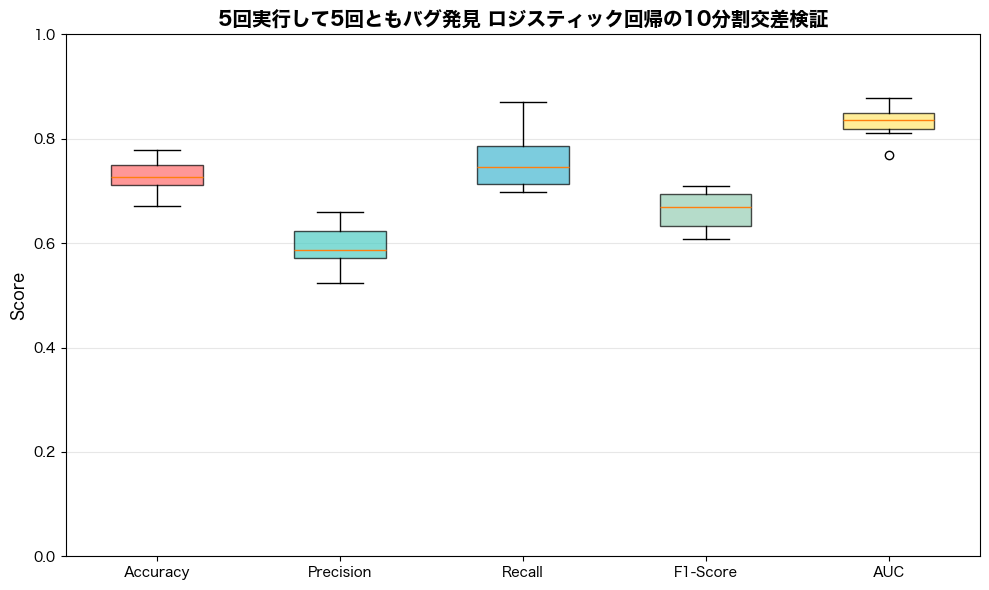

In [9]:
# 交差検証の結果をグラフで表示
# 評価指標のリスト
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# 各評価指標のスコアを取得
test_scores = {
    'accuracy': cv_results['test_accuracy'],
    'precision': cv_results['test_precision'],
    'recall': cv_results['test_recall'],
    'f1': cv_results['test_f1'],
    'roc_auc': cv_results['test_roc_auc']
}

# 可視化: 箱ひげ図
_, ax = plt.subplots(figsize=(10, 6))

# テストスコアの箱ひげ図
test_data = [test_scores[m] for m in metrics]
bp = ax.boxplot(test_data, tick_labels=metric_labels, patch_artist=True)
# 箱の色を設定
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFE66D']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_title('5回実行して5回ともバグ発見 ロジスティック回帰の10分割交差検証', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [10]:
# ロジスティック回帰式の出力
print("="*70)
print("【ロジスティック回帰式】")
print("="*70)

# 注意: セル9でlr_model.fit(X, y)を実行しているため、
# 現在のlr_modelは標準化されていないデータで学習されたモデルです
# そのため、係数は元の変数に対するものです

print("\n【元の変数に対する回帰式（標準化なし）】")
print("-"*70)
print("logit(P) = β₀ + β₁·tree + β₂·cpNum + β₃·cpNum_range + β₄·cpNum_dir")
print("\nまたは確率の形式:")
print("P = 1 / (1 + exp(-(β₀ + β₁·tree + β₂·cpNum + β₃·cpNum_range + β₄·cpNum_dir)))")
print("\n係数:")
print(f"β₀ (切片) = {lr_model.intercept_[0]:.6f}")
for i, name in enumerate(feature_names):
    print(f"β_{i+1} ({name}) = {lr_model.coef_[0][i]:.6f}")

# 具体的な数値で表示
print("\n" + "="*70)
print("【具体的な回帰式（数値代入）】")
print("="*70)
print("logit(P) = {:.6f} + {:.6f}·tree + {:.6f}·cpNum + {:.6f}·cpNum_range + {:.6f}·cpNum_dir".format(
    lr_model.intercept_[0], 
    lr_model.coef_[0][0], 
    lr_model.coef_[0][1], 
    lr_model.coef_[0][2], 
    lr_model.coef_[0][3]
))
print("\n確率の形式:")
print("P = 1 / (1 + exp(-({:.6f} + {:.6f}·tree + {:.6f}·cpNum + {:.6f}·cpNum_range + {:.6f}·cpNum_dir)))".format(
    lr_model.intercept_[0], 
    lr_model.coef_[0][0], 
    lr_model.coef_[0][1], 
    lr_model.coef_[0][2], 
    lr_model.coef_[0][3]
))

# 標準化されたデータで学習したモデルの係数も表示（セル5で学習したモデル）
# 標準化された変数に対する回帰式
print("\n" + "="*70)
print("【標準化された変数に対する回帰式（セル5で学習したモデル）】")
print("="*70)
print("注意: この式は標準化された変数（平均0、標準偏差1）に対するものです")
print("\nlogit(P) = β₀ + β₁·tree_scaled + β₂·cpNum_scaled + β₃·cpNum_range_scaled + β₄·cpNum_dir_scaled")
print("\nまたは確率の形式:")
print("P = 1 / (1 + exp(-(β₀ + β₁·tree_scaled + β₂·cpNum_scaled + β₃·cpNum_range_scaled + β₄·cpNum_dir_scaled)))")

# 標準化されたデータで再学習して係数を取得
scaler_for_eq = StandardScaler()
X_scaled_for_eq = scaler_for_eq.fit_transform(X)
lr_model_scaled = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model_scaled.fit(X_scaled_for_eq, y)

print("\n係数（標準化された変数に対する）:")
print(f"β₀ (切片) = {lr_model_scaled.intercept_[0]:.6f}")
for i, name in enumerate(feature_names):
    print(f"β_{i+1} ({name}_scaled) = {lr_model_scaled.coef_[0][i]:.6f}")

# 標準化された係数から元の変数に対する係数を計算
# 標準化: x_scaled = (x - mean) / std
# 元の変数に対する係数: coef_original = coef_scaled / std
# 切片: intercept_original = intercept_scaled - sum(coef_scaled * mean / std)
coef_original_from_scaled = lr_model_scaled.coef_[0] / scaler_for_eq.scale_
intercept_original_from_scaled = lr_model_scaled.intercept_[0] - np.sum(lr_model_scaled.coef_[0] * scaler_for_eq.mean_ / scaler_for_eq.scale_)

print("\n" + "="*70)
print("【標準化モデルから変換した元の変数に対する回帰式】")
print("="*70)
print("logit(P) = β₀ + β₁·tree + β₂·cpNum + β₃·cpNum_range + β₄·cpNum_dir")
print("\n係数:")
print(f"β₀ (切片) = {intercept_original_from_scaled:.6f}")
for i, name in enumerate(feature_names):
    print(f"β_{i+1} ({name}) = {coef_original_from_scaled[i]:.6f}")

【ロジスティック回帰式】

【元の変数に対する回帰式（標準化なし）】
----------------------------------------------------------------------
logit(P) = β₀ + β₁·tree + β₂·cpNum + β₃·cpNum_range + β₄·cpNum_dir

または確率の形式:
P = 1 / (1 + exp(-(β₀ + β₁·tree + β₂·cpNum + β₃·cpNum_range + β₄·cpNum_dir)))

係数:
β₀ (切片) = -0.931352
β_1 (tree) = -0.000422
β_2 (cpNum) = 0.000720
β_3 (cpNum_range) = 0.023613
β_4 (cpNum_dir) = -0.121475

【具体的な回帰式（数値代入）】
logit(P) = -0.931352 + -0.000422·tree + 0.000720·cpNum + 0.023613·cpNum_range + -0.121475·cpNum_dir

確率の形式:
P = 1 / (1 + exp(-(-0.931352 + -0.000422·tree + 0.000720·cpNum + 0.023613·cpNum_range + -0.121475·cpNum_dir)))

【標準化された変数に対する回帰式（セル5で学習したモデル）】
注意: この式は標準化された変数（平均0、標準偏差1）に対するものです

logit(P) = β₀ + β₁·tree_scaled + β₂·cpNum_scaled + β₃·cpNum_range_scaled + β₄·cpNum_dir_scaled

または確率の形式:
P = 1 / (1 + exp(-(β₀ + β₁·tree_scaled + β₂·cpNum_scaled + β₃·cpNum_range_scaled + β₄·cpNum_dir_scaled)))

係数（標準化された変数に対する）:
β₀ (切片) = -0.283659
β_1 (tree_scaled) = 0.128433
β_2 (cpNum_scaled) = 0.47